# Version information

In [1]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: June 21, 2022
Pyleecan version:1.3.7
SciDataTool version:1.4.24


# Force Module을 사용하여 자기력을 계산하는 방법

이 튜토리얼은 pyleecan으로 **자기력을 계산**하는 다양한 단계를 보여줍니다.
 
이 튜토리얼과 관련된 노트북은 [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_Force.ipynb)에서 볼 수 있습니다.

SciDataTool 개체의 기능과 사용을 입증하기 위해 FEMM을 사용하여 시뮬레이션을 실행하고 전류를 가하고 실행 시간을 줄이기 위해 주기성과 병렬화를 사용합니다.

In [2]:

from os.path import join
from numpy import (
    zeros,
    exp,
    pi,
    real,
    meshgrid,
    mean,
)
from numpy.testing import assert_array_almost_equal

from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent

from pyleecan.Functions.load import load
from pyleecan.Functions.Plot import dict_2D, dict_3D
from pyleecan.definitions import DATA_DIR


"""Validation of the AGSF spectrum calculation for IPMSM machine with symmetries"""
# Test 2 : With sym

# Load machine
Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))
# Prepare simulation
simu2 = Simu1(name="test_IPMSM_AGSF_spectrum_sym", machine=Toyota_Prius)

simu2.input = InputCurrent(
    OP=OPdq(Id_ref=0, Iq_ref=0, N0=1200),
    Ir=None,
    Na_tot=2 ** 6,
    Nt_tot=4 * 2 ** 4,
)

simu2.elec = None

simu2.mag = MagFEMM(
    type_BH_stator=1,
    type_BH_rotor=1,
    is_periodicity_a=False,
    is_periodicity_t=False,
)
simu2.force = ForceMT(
    is_periodicity_a=False,
    is_periodicity_t=False,
)

simu2.mag.is_periodicity_a = True
simu2.mag.is_periodicity_t = True

simu2.force.is_periodicity_a = True
simu2.force.is_periodicity_t = True

out = simu2.run()

AGSF = out.force.AGSF

arg_list = ["time", "angle"]
result = AGSF.get_rphiz_along(*arg_list)
Prad = result["radial"]
time = result["time"]
angle = result["angle"]
Xangle, Xtime = meshgrid(angle, time)

# Check time_to_freq reversibility
AGSF_rad_freq = AGSF.components["radial"].time_to_freq()
result_frq = AGSF_rad_freq.get_along(*arg_list)
Prad_frq = result_frq["AGSF_r"]


AGSF2 = AGSF_rad_freq.freq_to_time()
result2 = AGSF2.get_along(*arg_list)
Prad2 = result2["AGSF_r"]

# Check time-space reconstruction
arg_list = ["freqs", "wavenumber"]
result_freq = AGSF.get_rphiz_along(*arg_list)
Prad_wr = result_freq["radial"]
freqs_AGSF = result_freq["freqs"]
wavenumber = result_freq["wavenumber"]
Nf = len(freqs_AGSF)
Nr = len(wavenumber)




[01:32:14] Starting running simulation test_IPMSM_AGSF_spectrum_sym (machine=Toyota_Prius)
[01:32:14] Starting Magnetic module
[01:32:15] Solving time step 1 / 8 in FEMM
[01:32:15] Solving time step 2 / 8 in FEMM
[01:32:15] Solving time step 3 / 8 in FEMM
[01:32:16] Solving time step 4 / 8 in FEMM
[01:32:16] Solving time step 5 / 8 in FEMM
[01:32:16] Solving time step 6 / 8 in FEMM
[01:32:16] Solving time step 7 / 8 in FEMM
[01:32:17] Solving time step 8 / 8 in FEMM
[01:32:17] Starting Force module
[01:32:17] End of simulation test_IPMSM_AGSF_spectrum_sym


## 공간 자속밀도분포(공극)

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_3D.py:354: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_4D.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


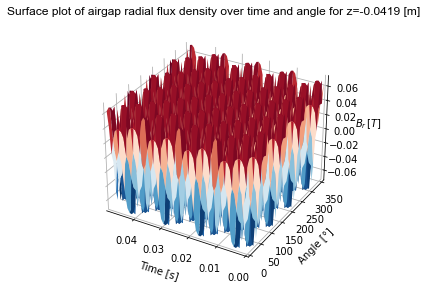

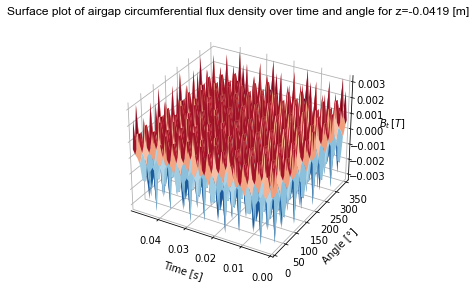

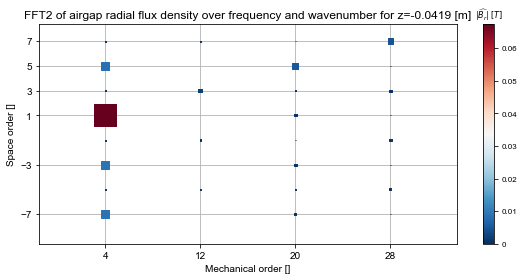

In [3]:
out.mag.B.plot_3D_Data("time", "angle{°}", is_2D_view=False, **dict_3D
)
out.mag.B.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[-48,48]",
    N_stem=100,
    
    component_list=["radial"],
    is_2D_view=True,
    **dict_3D

)

## 포스 모듈
Force 추상 클래스를 사용하면 힘을 계산하는 다양한 방법을 정의할 수 있습니다.

ForceMT 클래스는 Force 클래스에서 상속됩니다. ForceMT는 Maxwell 응력 텐서 \[[source](https://eomys.com/IMG/pdf/comparison-main-magnetic.pdf)\]를 기반으로 하는 공극 표면력 계산에 전념합니다.

여기서 우리는 힘 계산 없이 자기 시뮬레이션의 결과를 얻습니다. Force 모듈은 초기화되고 단독으로 실행됩니다.
시뮬레이션이 완료되면 결과가 출력의 force 부분(예: _myResults.force_ )에 저장되고 다른 플롯을 호출할 수 있습니다. 이 개체에는 다음이 포함됩니다.
- *시간*: 시간 축
- *각도*: 각도 위치 축
- *AGSF*: 에어갭 표면력(방사형 및 접선 성분)
    
**출력** 개체는 결과를 쉽게 시각화하기 위해 다른 플롯을 포함합니다. 전용 튜토리얼은 [여기](https://www.pyleecan.org/tuto_Plots.html)에서 찾을 수 있습니다.

다음은 유용한 플롯의 몇 가지 예입니다.

In [5]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Functions.Plot import dict_2D, dict_3D
import matplotlib.pyplot as plt


AGSF_rad_freq.plot_2D_Data_Animated("time",save_path="D:/AGSF.gif",)
AGSF_rad_freq.plot_2D_Data("time")
AGSF.plot_2D_Data('time')
AGSF.plot_2D_Data('angle')


   

UnboundLocalError: local variable 'xticks' referenced before assignment

다음 플롯은 시간과 각도에 따른 방사형 에어 갭 표면력을 표시합니다.

The following plot displays the radial air-gap surface force over time and angle. 

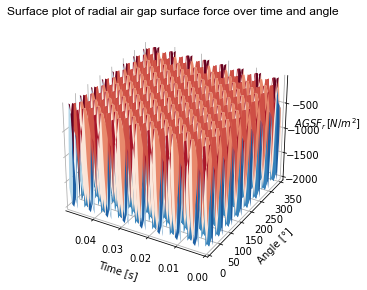

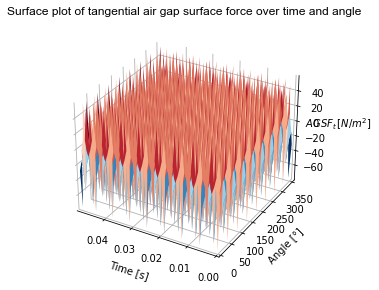

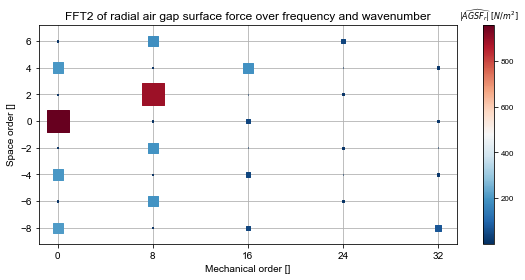

In [6]:
AGSF.plot_3D_Data("time", "angle{°}", is_2D_view=False, **dict_3D)
AGSF.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[-48,48]",
    N_stem=100,
    
    component_list=["radial"],
    is_2D_view=True,
    **dict_3D

)
#------------------------------------------------------

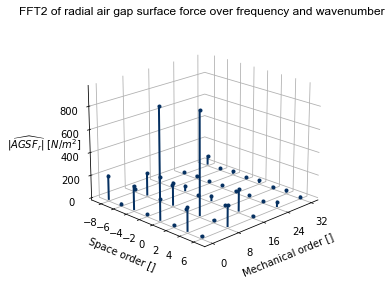

In [7]:
AGSF.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[-48,48]",
    N_stem=100,
    
    component_list=["radial"],
    is_2D_view=False,
    **dict_3D

)
#------------------------------------------------------

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


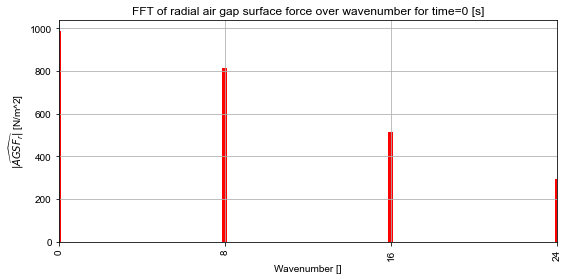

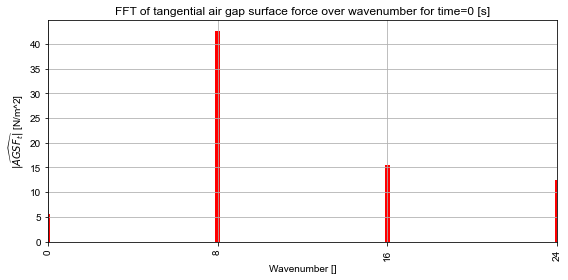

In [8]:
AGSF.plot_2D_Data("wavenumber=[0,78]", **dict_2D)

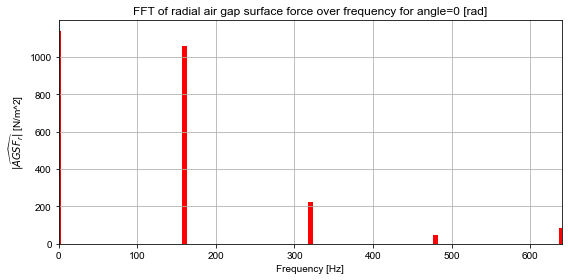

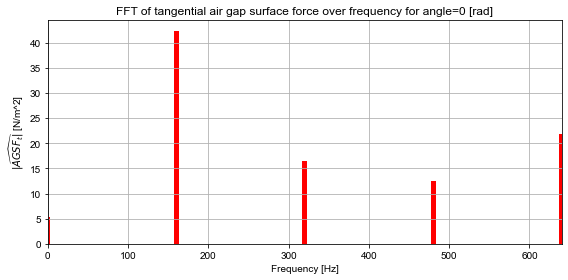

In [9]:
AGSF.plot_2D_Data("freqs=[0,4000]", is_auto_ticks=False, **dict_2D)

In [10]:
## reverse
t=AGSF.components["radial"].time_to_freq()

In [11]:
AGSF.components["radial"].as_dict()

{'symbol': 'AGSF_r',
 'name': 'Radial air gap surface force',
 'unit': 'N/m^2',
 'normalizations': {},
 '__class__': 'DataTime',
 'axes': [{'symbol': '',
   'name': 'time',
   'unit': 's',
   'normalizations': {'elec_order': {'unit': 'SI',
     '__class__': 'Norm_ref',
     'ref': 80.0},
    'mech_order': {'unit': 'SI', '__class__': 'Norm_ref', 'ref': 20.0},
    'angle_elec': {'unit': 'SI',
     '__class__': 'Norm_ref',
     'ref': -0.0019894367886486917},
    'angle_rotor': {'unit': 'SI',
     '__class__': 'Norm_affine',
     'slope': -7200.0,
     'offset': 52.425000000000004}},
   '__class__': 'DataLinspace',
   'initial': 0,
   'final': 0.0054687500000000005,
   'step': None,
   'number': 8,
   'include_endpoint': True,
   'is_components': False,
   'symmetries': {'period': 8}},
  {'symbol': '',
   'name': 'angle',
   'unit': 'rad',
   'normalizations': {'space_order': {'unit': 'SI',
     '__class__': 'Norm_ref',
     'ref': 4},
    'distance': {'unit': 'SI',
     '__class__': 'Nor